In [151]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.impute import KNNImputer
import imblearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
from scipy.stats import skew
from sklearn.manifold import TSNE # TSNE module
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, balanced_accuracy_score, f1_score, mean_squared_error



from utils.general_utils import get_outlier_info, get_outlier_val_counts, clean_outliers
from utils.saver_utils import save_normalizer, load_normalizer
from utils.saver_utils import save_dataset, load_dataset 

from sklearn.ensemble import RandomForestRegressor


In [49]:
def run_RF(trainX, testX, trainY, testY):
    # trainX, testX, trainY, testY = train_test_split(X,Y, test_size=0.20)
    regressor = RandomForestRegressor()
    regressor.fit(trainX, trainY.ravel())

    predicted = regressor.predict(testX)
    test_mse_error = mean_squared_error(testY, predicted,)
    test_mae_error = mean_absolute_error(testY, predicted)
    test_r2_error = r2_score(testY, predicted)
    print('TEST METRICS')
    print(f'MSE error: {test_mse_error}')
    print(f'MAE error: {test_mae_error}')
    print(f'R2 error: {test_r2_error}')
    print()
    predicted = regressor.predict(trainX)
    test_mse_error = mean_squared_error(trainY, predicted,)
    test_mae_error = mean_absolute_error(trainY, predicted)
    test_r2_error = r2_score(trainY, predicted)
    print('TRAIN METRICS')
    print(f'MSE error: {test_mse_error}')
    print(f'MAE error: {test_mae_error}')
    print(f'R2 error: {test_r2_error}')
    

In [3]:
def knn_impute(df, missing_val_indicator=999, int_col_index:list=[]):
    
    missing_vals = np.sum(df == missing_val_indicator)
    missing_cols_valuecounts = missing_vals[missing_vals > 0]
    impute_knn = KNNImputer(n_neighbors=3, missing_values=999)
    imputed_arr = impute_knn.fit_transform(df.drop(columns=['ID']))
    
    for idx in int_col_index:
        imputed_arr[:, idx] = np.rint(imputed_arr[:, idx])

    imputed_df = pd.DataFrame.from_records(imputed_arr, columns=df.columns[1:])
    
    return imputed_df

def get_cat_to_one_hot(df, multi_cat_cols):
    df = pd.get_dummies(df, columns=multi_cat_cols)
    
    multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']
    
    for column in multi_category_variables:
        df[column] = df[column].astype(np.float32)
        
    return df
    

In [4]:
og_df = pd.read_csv('dataset/TrainDataset2023.csv')
og_df.rename(columns={'pCR (outcome)': 'pcr', 'RelapseFreeSurvival (outcome)': 'rfs'}, inplace=True)

In [5]:

int_col_mask = og_df.drop(columns=['ID']).dtypes == 'int64'
categorical_features = list(og_df.drop(columns=['ID']).columns[int_col_mask])

# Ignoring 'original_shape_VoxelVolume' because even though it is a int column it is not a categorical feature


In [6]:
categorical_features.remove('original_shape_VoxelVolume')


In [7]:

int_col_index = [i for i, x in enumerate(np.array(int_col_mask)) if x]

imputed_df = knn_impute(og_df, int_col_index = int_col_index)
multiclass_categorical_features = []
others = []

for cat_col_name in categorical_features:
    temp_len = len(imputed_df[cat_col_name].value_counts())
    if temp_len > 2:
        multiclass_categorical_features.append(cat_col_name)
    else:
        others.append(temp_len)

multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = categorical_features + multi_category_variables
temp_categorical_features_labels = categorical_features_labels

# Removing multiclass_categorical_features because these features are 
# converted to one-hot encoding

for col_name in multiclass_categorical_features:
    temp_categorical_features_labels.remove(col_name)

temp_categorical_features_labels.remove('pcr')



In [8]:

imputed_df = get_cat_to_one_hot(imputed_df, multi_cat_cols=multiclass_categorical_features)
imputed_df.head()


nan_cols = imputed_df.columns[imputed_df.isnull().sum() > 0]

print(f'NaN Columns : {nan_cols}')
if len(nan_cols) > 0:
    imputed_df.drop(columns=nan_cols, inplace=True)


NaN Columns : Index([], dtype='object')


# Dropping Highly correlated features

In [10]:
# # Taking values above the diagonal getting the values only from it and making the other elements to NaN.
# corr = imputed_df.drop(columns=['pcr', 'rfs']).corr() 
# corr_abs = corr.abs()
# upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

# #Then taking values (absolute) of the each element and choosing the column to drop by various correlation threshold vales
# to_drop_95 = [column for column in upper.columns if any(upper[column] > 0.95)]
# to_drop_90 = [column for column in upper.columns if any(upper[column] > 0.90)]
# to_drop_85 = [column for column in upper.columns if any(upper[column] > 0.85)]
# to_drop_80 = [column for column in upper.columns if any(upper[column] > 0.80)]

# print(f'Thresholding 95% correlated drop columns : {len(to_drop_95)}')
# print(f'Thresholding 90% correlated drop columns : {len(to_drop_90)}')
# print(f'Thresholding 85% correlated drop columns : {len(to_drop_85)}')
# print(f'Thresholding 80% correlated drop columns : {len(to_drop_80)}')

# imputed_df_corr_removed = imputed_df.drop(to_drop_80, axis=1)

In [220]:
imputed_df.columns

Index(['pcr', 'rfs', 'Age', 'ER', 'PgR', 'HER2', 'TrippleNegative',
       'HistologyType', 'LNStatus', 'original_shape_Elongation',
       ...
       'ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0',
       'Proliferation_1.0', 'Proliferation_2.0', 'Proliferation_3.0',
       'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0',
       'TumourStage_4.0'],
      dtype='object', length=126)

In [231]:
temp_corr = imputed_df.corr()

In [232]:
temp_corr.head()

,pcr,rfs,Age,ER,PgR,HER2,TrippleNegative,HistologyType,LNStatus,original_shape_Elongation,...,ChemoGrade_1.0,ChemoGrade_2.0,ChemoGrade_3.0,Proliferation_1.0,Proliferation_2.0,Proliferation_3.0,TumourStage_1.0,TumourStage_2.0,TumourStage_3.0,TumourStage_4.0
pcr,1.000000,-0.005779,-0.001893,-0.197180,-0.200306,0.211624,0.076205,-0.044693,-0.146932,0.028734,...,0.050472,-0.069386,0.062267,-0.077474,-0.036761,0.142485,0.068879,0.031663,0.030225,-0.115130
rfs,-0.005779,1.000000,-0.059959,0.014400,0.047658,0.077706,-0.038765,0.016077,-0.000409,0.046683,...,-0.022668,0.117625,-0.114594,0.091903,-0.109218,0.002841,-0.012570,0.179478,-0.120043,-0.082246
Age,-0.001893,-0.059959,1.000000,0.005765,-0.117406,0.038338,-0.060773,0.166465,0.118127,-0.031820,...,0.031087,0.032593,-0.037122,0.041764,-0.051389,0.003266,0.085350,-0.052630,-0.117167,0.136213
ER,-0.197180,0.014400,0.005765,1.000000,0.698884,0.101932,-0.770077,0.128708,0.189671,-0.110106,...,0.064445,0.253161,-0.262906,0.257562,-0.141701,-0.176903,-0.075104,-0.102760,0.035039,0.135770
PgR,-0.200306,0.047658,-0.117406,0.698884,1.000000,0.004445,-0.585572,0.138347,0.156528,-0.075347,...,0.013719,0.273570,-0.276066,0.282521,-0.128577,-0.224247,-0.053910,-0.103401,0.056659,0.099778


pcr                  0.005779
rfs                  1.000000
Age                  0.059959
ER                   0.014400
PgR                  0.047658
                       ...   
Proliferation_3.0    0.002841
TumourStage_1.0      0.012570
TumourStage_2.0      0.179478
TumourStage_3.0      0.120043
TumourStage_4.0      0.082246
Name: rfs, Length: 126, dtype: float64

<Axes: >

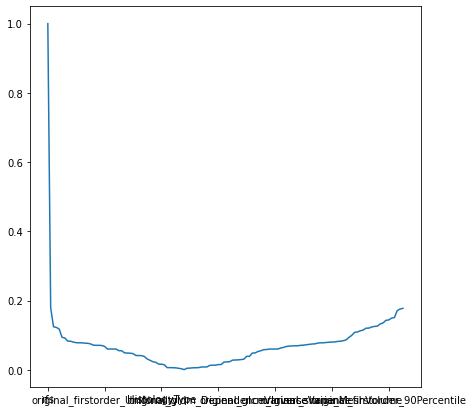

In [243]:
abs(temp_corr['rfs'].sort_values(ascending=False)).plot(kind='line', figsize=(7,7))

In [246]:
list(imputed_df.columns)

['pcr',
 'rfs',
 'Age',
 'ER',
 'PgR',
 'HER2',
 'TrippleNegative',
 'HistologyType',
 'LNStatus',
 'original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxisLength',
 'original_shape_MajorAxisLength',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Maximum3DDiameter',
 'original_shape_MeshVolume',
 'original_shape_MinorAxisLength',
 'original_shape_Sphericity',
 'original_shape_SurfaceArea',
 'original_shape_SurfaceVolumeRatio',
 'original_shape_VoxelVolume',
 'original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'o

In [224]:
pair[0]

'ChemoGrade_3.0'

In [20]:


# Load your data
# data = pd.read_csv('your_dataset.csv')

target = 'rfs'

# Step 1: Compute the correlation matrix
correlation_matrix = imputed_df.drop(columns=['rfs', 'pcr']).corr()

# Step 2: Identify pairs of highly correlated features
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_pairs.append((correlation_matrix.columns[j], colname))

# Step 3 and 4: Remove the feature from each pair with lower correlation with the target
features_to_remove = set()
for pair in high_corr_pairs:
    if abs(imputed_df[pair[0]].corr(imputed_df[target])) > abs(imputed_df[pair[1]].corr(imputed_df[target])):
        features_to_remove.add(pair[1])
    else:
        features_to_remove.add(pair[0])

# Creating a new dataset with reduced features
imputed_df_reduced = imputed_df.drop(columns=features_to_remove)

# Now you can proceed with splitting the data and applying your model
# X = data_reduced.drop(columns=[target])
# y = data_reduced[target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ... Continue with your model training and evaluation


In [24]:
imputed_df_reduced.shape

(400, 44)

In [39]:
train, test = train_test_split(imputed_df_reduced, test_size=0.20)

In [33]:
categorical_cols = []
for col in imputed_df_reduced.drop(columns=['pcr', 'rfs']):
    if len(imputed_df_reduced[col].value_counts().index) < 4:
        categorical_cols.append(col)

In [37]:
categorical_cols, len(categorical_cols)

(['ER',
  'PgR',
  'HER2',
  'TrippleNegative',
  'HistologyType',
  'LNStatus',
  'ChemoGrade_1.0',
  'ChemoGrade_2.0',
  'Proliferation_2.0',
  'Proliferation_3.0',
  'TumourStage_1.0',
  'TumourStage_2.0',
  'TumourStage_3.0',
  'TumourStage_4.0'],
 14)

In [42]:
trainX_df = train.drop(columns=['pcr', 'rfs'])
trainY_df = train['rfs']

testX_df = test.drop(columns=['pcr', 'rfs'])
testY_df = test['rfs']

multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = ['ER', 'PgR', 'LNStatus', 'HER2', 'HistologyType', 'TrippleNegative'] + multi_category_variables

continous_features_labels = imputed_df_reduced.drop(columns=categorical_features_labels + ['pcr', 'rfs']).columns


In [129]:
trainX_continous_feature_array = trainX_df[continous_features_labels].to_numpy()
testX_continous_feature_array = testX_df[continous_features_labels].to_numpy()


scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


trainX_cont_X = scalerTrainX.fit_transform(trainX_continous_feature_array)
testX_cont_X = scalerTrainX.transform(testX_continous_feature_array)

trainX_cat_X = train[categorical_features_labels].to_numpy()
testX_cat_X = test[categorical_features_labels].to_numpy()


trainX = np.hstack((trainX_cat_X, trainX_cont_X))   
testX = np.hstack((testX_cat_X, testX_cont_X))              

trainY = scalerTrainY.fit_transform(train['rfs'].to_numpy().reshape(-1, 1))
pcrtrainY = train['pcr'].to_numpy().reshape(-1, 1)

testY = scalerTrainY.transform(test['rfs'].to_numpy().reshape(-1, 1))
pcrtestY = test['pcr'].to_numpy().reshape(-1, 1)




In [44]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((320, 42), (80, 42), (320, 1), (80, 1))

In [52]:
run_RF(trainX, testX, trainY, testY)

TEST METRICS
MSE error: 0.04257266481389791
MAE error: 0.16130956572684857
R2 error: -0.0665099665500728

TRAIN METRICS
MSE error: 0.004561844314985147
MAE error: 0.05320767312213466
R2 error: 0.8717057290111179


In [74]:
import imblearn

In [79]:
a = np.hstack((trainX, trainY))

In [91]:
# a[:, -1] ==  trainY.ravel()
a.shape

(320, 43)

In [90]:
imputed_x[:, :-1].shape, imputed_x.shape

((494, 42), (494, 43))

In [92]:
# oversample = imblearn.over_sampling.BorderlineSMOTE(sampling_strategy=1)
oversample = imblearn.over_sampling.ADASYN()


imputed_x, imputed_y = oversample.fit_resample(np.hstack((trainX, trainY)), pcrtrainY)

train_smote_X = imputed_x[:, :-1]
train_smote_Y = imputed_x[:, -1]

In [93]:
train_smote_X.shape, train_smote_Y.shape

((494, 42), (494,))

In [94]:
run_RF(train_smote_X, testX, train_smote_Y, testY)

TEST METRICS
MSE error: 0.041198466950229704
MAE error: 0.16371505158326585
R2 error: -0.03208422120336607

TRAIN METRICS
MSE error: 0.0029659204531387803
MAE error: 0.03916584704186181
R2 error: 0.9014347880961205


In [120]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

from tensorflow.keras import layers, regularizers, models
from sklearn.utils.class_weight import compute_class_weight

In [96]:
# Enable eager execution
tf.config.run_functions_eagerly(True)

In [97]:
trainX.shape[1]

42

In [162]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 42)]         0           []                               
                                                                                                  
 dense_77 (Dense)               (None, 32)           1376        ['input_18[0][0]']               
                                                                                                  
 dropout_35 (Dropout)           (None, 32)           0           ['dense_77[0][0]']               
                                                                                                  
 dense_78 (Dense)               (None, 16)           528         ['dropout_35[0][0]']             
                                                                                           

In [163]:


# # Custom Binary Classification Metrics
# class BalancedAccuracy(tf.keras.metrics.Metric):
#     def __init__(self, name='balanced_accuracy', **kwargs):
#         super(BalancedAccuracy, self).__init__(name=name, **kwargs)
#         self.true_positives = self.add_weight(name='true_positives', initializer='zeros')
#         self.true_negatives = self.add_weight(name='true_negatives', initializer='zeros')
#         self.false_positives = self.add_weight(name='false_positives', initializer='zeros')
#         self.false_negatives = self.add_weight(name='false_negatives', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.keras.backend.cast(y_true, tf.float32)
#         y_pred = tf.keras.backend.cast(y_pred, tf.float32)

#         true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
#         true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1 - y_true) * (1 - y_pred), 0, 1)))
#         false_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1 - y_true) * y_pred, 0, 1)))
#         false_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * (1 - y_pred), 0, 1)))

#         self.true_positives.assign_add(true_positives)
#         self.true_negatives.assign_add(true_negatives)
#         self.false_positives.assign_add(false_positives)
#         self.false_negatives.assign_add(false_negatives)

#     def result(self):
#         balanced_accuracy = (self.true_positives / (self.true_positives + self.false_negatives) +
#                              self.true_negatives / (self.true_negatives + self.false_positives)) / 2.0
#         return balanced_accuracy

#     def reset_states(self):
#         self.true_positives.assign(0)
#         self.true_negatives.assign(0)
#         self.false_positives.assign(0)
#         self.false_negatives.assign(0)

# class F1Score(tf.keras.metrics.Metric):
#     def __init__(self, name='f1_score', **kwargs):
#         super(F1Score, self).__init__(name=name, **kwargs)
#         self.true_positives = self.add_weight(name='true_positives', initializer='zeros')
#         self.false_positives = self.add_weight(name='false_positives', initializer='zeros')
#         self.false_negatives = self.add_weight(name='false_negatives', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.keras.backend.cast(y_true, tf.float32)
#         y_pred = tf.keras.backend.cast(y_pred, tf.float32)

#         true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
#         false_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1 - y_true) * y_pred, 0, 1)))
#         false_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * (1 - y_pred), 0, 1)))

#         self.true_positives.assign_add(true_positives)
#         self.false_positives.assign_add(false_positives)
#         self.false_negatives.assign_add(false_negatives)

#     def result(self):
#         precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
#         recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
#         f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
#         return f1

#     def reset_states(self):
#         self.true_positives.assign(0)
#         self.false_positives.assign(0)
#         self.false_negatives.assign(0)


# Custom R2 metric
def r2_metric(y_true, y_pred):
    return tf.py_function(r2_score, (y_true, y_pred), tf.float32)

# Custom Balanced Accuracy metric
def balanced_accuracy_metric(y_true, y_pred):
    return tf.py_function(balanced_accuracy_score, (y_true, tf.round(y_pred)), tf.float32)

# Custom Reconstruction MSE metric
def reconstruction_mse(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return mse

# Custom F1 Score metric
def f1_score_metric(y_true, y_pred):
    return tf.py_function(f1_score, (y_true, tf.round(y_pred)), tf.float32)

# Custom Mean Squared Error (MSE) metric for regression
def mse_metric(y_true, y_pred):
    return tf.py_function(mean_squared_error, (y_true, y_pred), tf.float32)

In [178]:


# # Assuming 'data' is your preprocessed DataFrame
# X = data.drop(columns=['RelapseFreeSurvival (outcome)', 'pCR (outcome)'])  # Features
# y_reg = data['RelapseFreeSurvival (outcome)']  # Regression target
# y_clf = data['pCR (outcome)']  # Classification target

# Splitting the dataset (not shown here for brevity)

# Building the autoencoder architecture

dropout_rate = 0.3
l2_reg = 1

input_layer = Input(shape=(trainX.shape[1],))
encoded = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(input_layer,)
encoded = layers.Dropout(dropout_rate)(encoded)
encoded = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(encoded)
encoded = layers.Dropout(dropout_rate)(encoded)

encoded = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(encoded)
encoded = layers.Dropout(dropout_rate)(encoded)

decoded = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(encoded)
decoded = layers.Dropout(dropout_rate)(decoded)

decoded = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(decoded)
decoded = layers.Dropout(dropout_rate)(decoded)
decoded = Dense(trainX.shape[1], activation='sigmoid', name='decoded',
                kernel_regularizer=regularizers.l2(l2_reg))(decoded)

# Regression head
# regression_head = Dense(16, activation='relu')(encoded)
regression_output = Dense(1, activation='linear', name='regression_output' ,
                          kernel_regularizer=regularizers.l2(l2_reg))(encoded)
# Classification Head
classification_output = layers.Dense(1, activation='sigmoid', name='classification',
                                    kernel_regularizer=regularizers.l2(l2_reg))(encoded)

# Classification head
# classification_head = Dense(16, activation='relu')(encoded)
# classification_output = Dense(1, activation='sigmoid', name='classification_output')(classification_head)

# Model
model = Model(inputs=input_layer, outputs=[decoded, regression_output, classification_output])


In [179]:
# Custom R2 metric
# def r2_metric(y_true, y_pred):
#     r2 = r2_score(y_true, y_pred)
#     return r2

# # Custom Reconstruction MSE metric
# def reconstruction_mse(y_true, y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     return mse

# # Custom Regression MSE metric
# def regression_mse(y_true, y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     return mse
# Define the learning rate
learning_rate = 0.001  # Adjust as needed

# Create Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss={'decoded': 'mse', 'regression_output': 'mse', 'classification': 'binary_crossentropy'},
              loss_weights={'decoded': 0.3, 'regression_output': 1, 'classification': 0.2},
              metrics={'decoded': 'mse',
                       'regression_output': [mse_metric, r2_metric], 
                      'classification': [balanced_accuracy_metric, f1_score_metric]})


In [180]:

# Training the model
summary = model.fit(train_smote_X, {'decoded': train_smote_X, 'regression_output': train_smote_Y, 'classification':imputed_y}, 
          validation_data=(testX, {'decoded': testX, 'regression_output': testY, 'classification':pcrtestY}),
          epochs=200, batch_size=16)


Epoch 1/200


C:\Users\sudar\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


31/31 [==============================] - ETA: 0s - loss: 124.1290 - decoded_loss: 0.1613 - regression_output_loss: 0.1169 - classification_loss: 0.7550 - decoded_mse: 0.1613 - regression_output_mse_metric: 0.1170 - regression_output_r2_metric: -3.6550 - classification_balanced_accuracy_metric: 0.4665 - classification_f1_score_metric: 0.5509

C:\Users\sudar\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


31/31 [==============================] - 3s 99ms/step - loss: 124.1290 - decoded_loss: 0.1613 - regression_output_loss: 0.1169 - classification_loss: 0.7550 - decoded_mse: 0.1613 - regression_output_mse_metric: 0.1170 - regression_output_r2_metric: -3.6550 - classification_balanced_accuracy_metric: 0.4665 - classification_f1_score_metric: 0.5509 - val_loss: 106.4881 - val_decoded_loss: 0.1593 - val_regression_output_loss: 0.1140 - val_classification_loss: 0.7606 - val_decoded_mse: 0.1593 - val_regression_output_mse_metric: 0.1140 - val_regression_output_r2_metric: -2.5127 - val_classification_balanced_accuracy_metric: 0.5071 - val_classification_f1_score_metric: 0.2582
Epoch 2/200
31/31 [==============================] - 3s 98ms/step - loss: 92.7302 - decoded_loss: 0.1500 - regression_output_loss: 0.0904 - classification_loss: 0.7085 - decoded_mse: 0.1500 - regression_output_mse_metric: 0.0904 - regression_output_r2_metric: -2.6734 - classification_balanced_accuracy_metric: 0.4734 - cl

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
model.evaluate(X_test, {'regression_output': y_test_reg, 'classification_output': y_test_clf})

# RF with Linear regression post processor

In [183]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score


In [181]:
regressor = RandomForestRegressor()
regressor.fit(train_smote_X, train_smote_Y.ravel())

RandomForestRegressor()

In [185]:


predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(testY, predicted)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)
print('TEST METRICS')
print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')
print()
predicted = regressor.predict(trainX)
test_mse_error = mean_squared_error(trainY, predicted,)
test_mae_error = mean_absolute_error(trainY, predicted)
test_r2_error = r2_score(trainY, predicted)
print('TRAIN METRICS')
print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

TEST METRICS
MSE error: 0.04110539651418987
MAE error: 0.15787932805039612
R2 error: -0.029752665308014903

TRAIN METRICS
MSE error: 0.004699746059744034
MAE error: 0.05440448943664831
R2 error: 0.8678274721942817


In [187]:
testY.shape, predicted.shape

((80, 1), (320,))

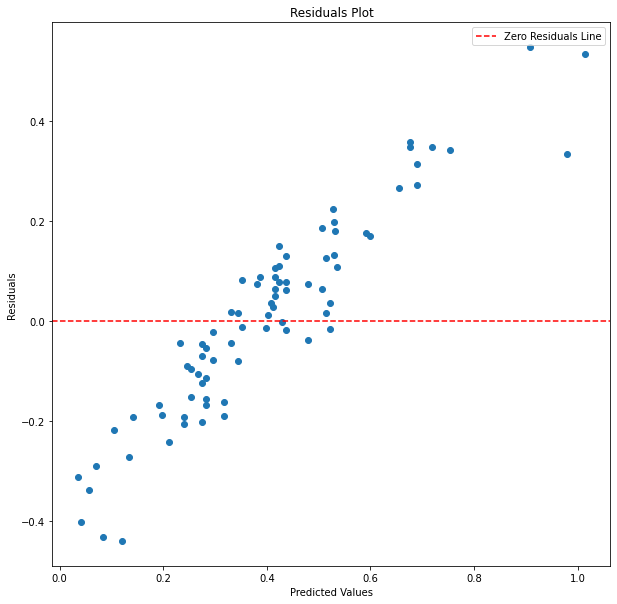

In [188]:
# Calculate residuals
predicted = regressor.predict(testX)

residuals = testY.ravel() - predicted

# Plot residuals
plt.figure(figsize=(10,10))
plt.scatter(testY.ravel(), residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Residuals Line")
plt.legend()
plt.show()

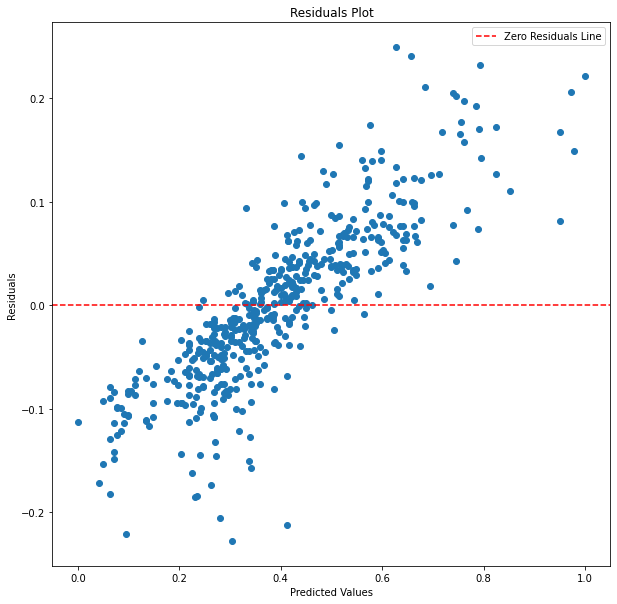

In [200]:
# Calculate residuals
train_predicted = regressor.predict(train_smote_X)

train_residuals = train_smote_Y.ravel() - train_predicted

# Plot residuals
plt.figure(figsize=(10,10))
plt.scatter(train_smote_Y.ravel(), train_residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Residuals Line")
plt.legend()
plt.show()

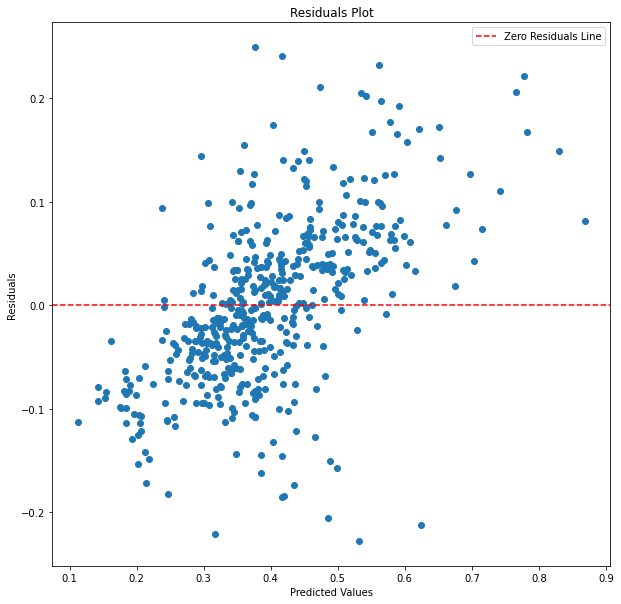

In [207]:

# Plot residuals
plt.figure(figsize=(10,10))
plt.scatter(train_predicted, train_residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Residuals Line")
plt.legend()
plt.show()

In [189]:
residuals

array([-0.12465376,  0.10984742,  0.19782864, -0.09555751, -0.10551643,
       -0.16911385, -0.03712441,  0.31409038, -0.04497653, -0.40299296,
       -0.15698944, -0.2915493 ,  0.04946009, -0.24297535, -0.02244131,
       -0.16293427, -0.06940728, -0.20605047, -0.01149648,  0.08730634,
        0.33371479, -0.31193662,  0.34362676,  0.17689554, -0.11394953,
       -0.15187793, -0.04537559, -0.44107981,  0.27251761,  0.03599178,
        0.03672535,  0.07468897, -0.19188967,  0.54921948,  0.12968897,
        0.35805164,  0.01232394, -0.01701291,  0.34850352,  0.06312207,
        0.53425469,  0.12527582, -0.43211854, -0.01840376, -0.00119131,
       -0.0131338 , -0.21860329,  0.17963615,  0.01532864, -0.16805751,
        0.13282864, -0.04447183,  0.15012324,  0.22491197,  0.07849178,
       -0.18967136, -0.33896127, -0.19200117,  0.3478169 , -0.27318662,
        0.0152054 ,  0.08188967,  0.08786385,  0.0643662 , -0.20170775,
       -0.18798122, -0.07803404, -0.08110915, -0.05330986,  0.06

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [203]:
train_residuals.shape, train_smote_Y.shape

((494,), (494,))

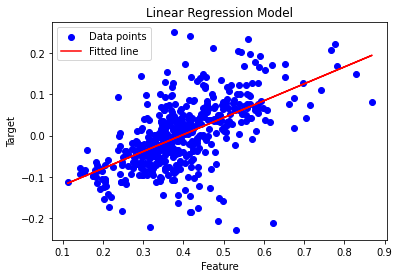

In [208]:

# Generating some sample data for the single feature linear regression model
# np.random.seed(0)
# x = np.random.rand(100, 1) * 100  # 100 random points between 0 and 100
# y = 3 * x + np.random.randn(100, 1) * 30  # A linear relationship with some noise

# Creating and training the linear regression model
model = LinearRegression()
model.fit(train_predicted.reshape(-1, 1), train_residuals.reshape(-1, 1))

# Predicting values for the training data
y_pred = model.predict(train_predicted.reshape(-1, 1))

# Plotting the data and the fitted model
plt.scatter(train_predicted, train_residuals, color='blue', label='Data points')
plt.plot(train_predicted, y_pred, color='red', label='Fitted line')
plt.title('Linear Regression Model')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

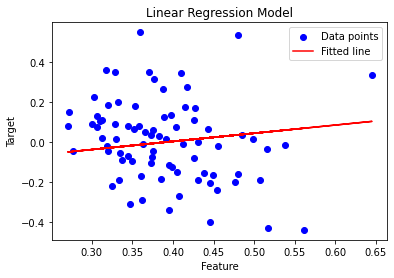

In [219]:
 # Predicting values for the training data

predicted = regressor.predict(testX)
y_pred = model.predict(predicted.reshape(-1, 1))
test_residuals = testY.ravel() - predicted

# Plotting the data and the fitted model
plt.scatter(predicted, test_residuals, color='blue', label='Data points')
plt.plot(predicted, y_pred, color='red', label='Fitted line')
plt.title('Linear Regression Model')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

In [209]:
predicted = regressor.predict(testX)
y_pred = model.predict(predicted.reshape(-1, 1))


In [212]:
predicted.shape, y_pred.ravel().shape

((80,), (80,))

In [217]:
pp_outs = predicted + y_pred.ravel()

In [218]:


test_mse_error = mean_squared_error(testY, pp_outs)
test_mae_error = mean_absolute_error(testY, pp_outs)
test_r2_error = r2_score(testY, pp_outs)
print('TEST METRICS')
print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

TEST METRICS
MSE error: 0.04443581369279065
MAE error: 0.16592633098740536
R2 error: -0.1131846780625414


In [245]:
list(og_df.columns)

['ID',
 'pcr',
 'rfs',
 'Age',
 'ER',
 'PgR',
 'HER2',
 'TrippleNegative',
 'ChemoGrade',
 'Proliferation',
 'HistologyType',
 'LNStatus',
 'TumourStage',
 'original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxisLength',
 'original_shape_MajorAxisLength',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow',
 'original_shape_Maximum2DDiameterSlice',
 'original_shape_Maximum3DDiameter',
 'original_shape_MeshVolume',
 'original_shape_MinorAxisLength',
 'original_shape_Sphericity',
 'original_shape_SurfaceArea',
 'original_shape_SurfaceVolumeRatio',
 'original_shape_VoxelVolume',
 'original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Mean',
 'original_firstorder_Median',
 'origina

In [249]:
gpt_chosen_columns = ['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade', 'HistologyType',
                     'LNStatus', 'TumourStage', 'original_shape_Elongation', 'Sphericity',
                      'original_shape_Sphericity', 'original_firstorder_Entropy',
                      'original_firstorder_Energy', 'pcr']

personal_chosen = ['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'HistologyType',
                     'LNStatus',  'original_shape_Elongation',
                      'original_shape_Sphericity', 'original_firstorder_Entropy',
                      'original_firstorder_Energy', 'pcr']

In [250]:
imputed_df[personal_chosen]

,Age,ER,PgR,HER2,TrippleNegative,HistologyType,LNStatus,original_shape_Elongation,original_shape_Sphericity,original_firstorder_Entropy,original_firstorder_Energy,pcr
0,41.0,0.0,0.0,0.0,1.0,1.0,1.0,0.813912,0.771675,0.738088,2897.689300,1.0
1,39.0,1.0,1.0,0.0,0.0,1.0,1.0,0.666118,0.603481,0.179893,41105.325100,0.0
2,31.0,0.0,0.0,0.0,1.0,1.0,0.0,0.645083,0.608183,0.136183,19774.948930,1.0
3,35.0,0.0,0.0,0.0,1.0,1.0,1.0,0.770842,0.474509,0.087137,72854.171510,0.0
4,61.0,1.0,0.0,0.0,0.0,1.0,0.0,0.861035,0.756228,0.183666,15697.309140,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,58.5,1.0,0.0,1.0,0.0,1.0,1.0,0.389439,0.574024,0.108749,21255.710020,0.0
396,34.3,0.0,0.0,0.0,1.0,1.0,0.0,0.915643,0.601545,0.699626,14484.595310,0.0
397,53.3,0.0,0.0,0.0,1.0,1.0,0.0,0.657236,0.670158,0.042800,4029.994702,0.0
398,68.8,1.0,0.0,0.0,0.0,1.0,1.0,0.890276,0.758747,0.379238,54652.156380,0.0


In [258]:

for col in imputed_df[personal_chosen].columns:
    if len(imputed_df[col].value_counts().index) > 2 and  len(imputed_df[col].value_counts().index) < 4:
        print(col)

In [ ]:
hand_imputed_df = get_cat_to_one_hot(imputed_df[personal_chosen], multi_cat_cols=multiclass_categorical_features)
imputed_df.head()

In [251]:
trainX, testX, trainY, testY = train_test_split(imputed_df[personal_chosen], 
                                                imputed_df['rfs'], test_size=0.20)

In [252]:
run_RF(trainX, testX, trainY, testY )

TEST METRICS
MSE error: 803.0920242123568
MAE error: 21.97405208332875
R2 error: -0.06554187403837886

TRAIN METRICS
MSE error: 113.10146489331882
MAE error: 8.348455729145002
R2 error: 0.8438155163163026


In [260]:
features_to_bin = [
    'original_shape_Elongation',
    'original_shape_Sphericity',
    'original_firstorder_Energy',
    'original_firstorder_Entropy',
    'original_firstorder_Kurtosis',
    'original_firstorder_Skewness',
    'original_glcm_Contrast',
    'original_glcm_Correlation'
]

In [265]:
f_in = []
f_not = []
for col in features_to_bin:
    if col in list(imputed_df_reduced.columns):
        f_in.append(col)
    else:
        f_not.append(col)

In [268]:
ff_not = []
for col in list(imputed_df_reduced.columns):
    if col not in features_to_bin:
        ff_not.append(col)

In [267]:
f_in, print(), f_not

(['original_shape_Sphericity',
  'original_firstorder_Kurtosis',
  'original_firstorder_Skewness'],
 None,
 ['original_shape_Elongation',
  'original_firstorder_Energy',
  'original_firstorder_Entropy',
  'original_glcm_Contrast',
  'original_glcm_Correlation'])

In [269]:
ff_not

['pcr',
 'rfs',
 'Age',
 'ER',
 'PgR',
 'HER2',
 'TrippleNegative',
 'HistologyType',
 'LNStatus',
 'original_shape_Flatness',
 'original_shape_MajorAxisLength',
 'original_shape_SurfaceVolumeRatio',
 'original_firstorder_90Percentile',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_glcm_ClusterShade',
 'original_glcm_MCC',
 'original_gldm_DependenceEntropy',
 'original_gldm_LargeDependenceHighGrayLevelEmphasis',
 'original_gldm_LargeDependenceLowGrayLevelEmphasis',
 'original_glrlm_LongRunLowGrayLevelEmphasis',
 'original_glrlm_LowGrayLevelRunEmphasis',
 'original_glrlm_RunLengthNonUniformity',
 'original_glrlm_ShortRunHighGrayLevelEmphasis',
 'original_glszm_LargeAreaLowGrayLevelEmphasis',
 'original_glszm_LowGrayLevelZoneEmphasis',
 'original_glszm_SizeZoneNonUniformity',
 'original_glszm_SmallAreaHighGrayLevelEmphasis',
 'original_glszm_ZoneEntropy',
 'original_glszm_ZonePercentage',
 'original_ngtdm_Busyness',

In [ ]:
def apply_binning(df, features_to_bin, num_bins=5):
    binned_features = {}
    for feature in features_to_bin:
        if feature in df.columns:
            binned_column_name = feature + '_binned'
            df[binned_column_name] = pd.cut(df[feature], bins=num_bins, labels=False)
            binned_features[feature] = binned_column_name
        else:
            print(f"Feature '{feature}' not found in DataFrame")
    return df, binned_features